In [173]:
# Notebook Setup
%matplotlib inline

# Libraries
import pandas as pd
import urllib.request

# Prepare the data

## Get global Dataset

In [174]:
# Get current dataset
with urllib.request.urlopen('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv') as f:
    #html = f.read().decode('utf-8')
    df_global = pd.read_csv(f, encoding = 'utf-8', index_col = [0], header = 0)
df_global.index = pd.to_datetime(df_global.index).date
df_global = df_global.set_index("Country",append = True,drop = True).reorder_levels([1,0])

In [175]:
df_global.to_pickle("Current_Global.pic")

## Get Germany Bundeslaender Dataset

In [176]:
# Get current dataset
with urllib.request.urlopen('https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv') as f:
    #html = f.read().decode('utf-8')
    df_ger = pd.read_csv(f, encoding = 'utf-8', index_col = [0], header = 0)

df_ger.index = pd.to_datetime(df_ger.index).date
df_ger.rename(columns = {"sum_cases": "Germany_detailed"}, inplace = True)

df_ger = df_ger.stack().to_frame("Confirmed")
df_ger.index = df_ger.index.reorder_levels([1,0]).set_names(["Country", "Date"])
df_ger = df_ger.sort_index()

In [177]:
# Save a cached version    
df_ger.to_pickle("Current_Germany.pic")

## Combine the two datasets

In [178]:
df = pd.concat([df_ger,df_global], sort = True).sort_index()
df.to_pickle("Current.pic")

# Plotting

## Read Dataset

In [179]:
df = pd.read_pickle("Current.pic").sort_index()

## Compute metrics

In [180]:
# Daily new infections
df["NewConfirmed"] = df.groupby(level = 0)["Confirmed"].diff()

# Daily new Removed
df["NewRemoved"] = df.groupby(level = 0)["Recovered"].diff() + df.groupby(level = 0)["Deaths"].diff()

## Weekly smoothing

In [181]:
# Daily new infections (averaged over 7 days to eliminate the weekly testing cycles)
df["weeklyAverage"] = df.groupby(level = "Country")["NewConfirmed"].rolling(7, center = True ).mean().values

## Plot

### Select countries and plotting period

In [182]:
#Select
countries = ['Germany',"DE-BY",'United Kingdom', 'US','Italy']
lastXdays = 130

### Plot logarithmic timelines of new infections

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


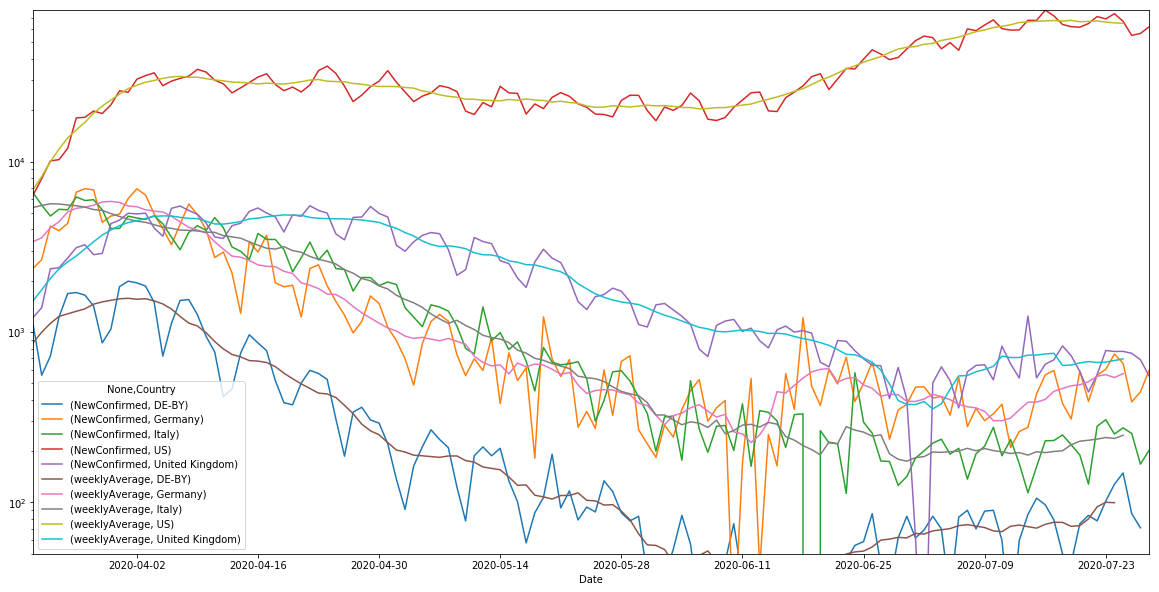

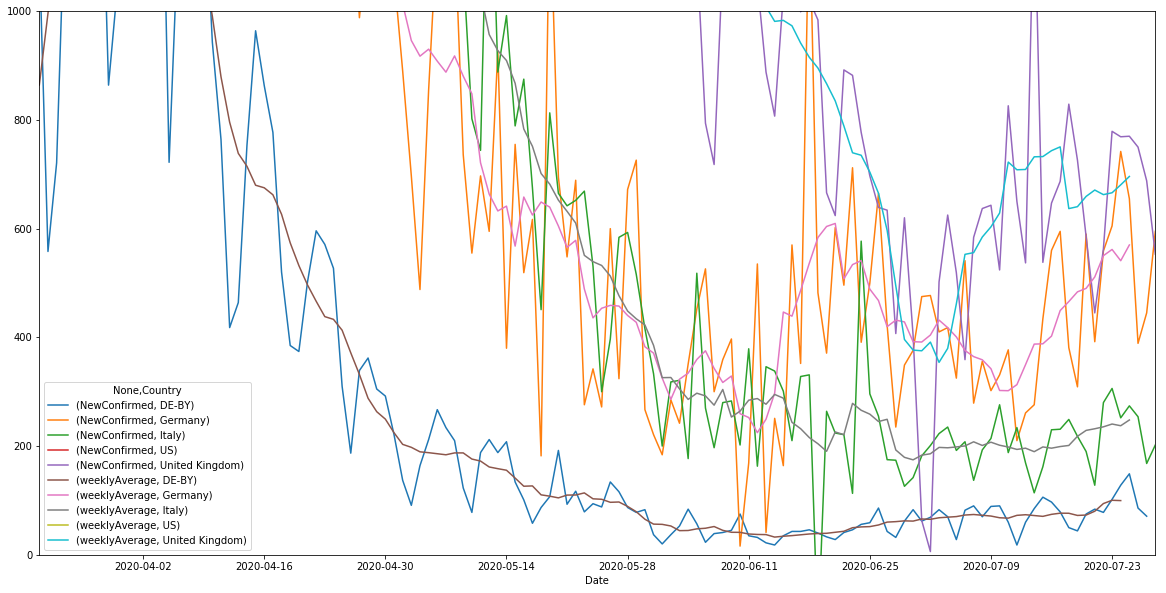

In [183]:
# Filter ...
to_plot = df.loc[
    df.index.get_level_values("Country").isin(countries),
    df.columns.get_level_values(0).isin(["weeklyAverage", "NewConfirmed"])
    ]

# .. and plot 
unstacked = to_plot.unstack(level="Country").iloc[-lastXdays:].dropna(how = 'all')\

unstacked.plot(
    figsize = (20,10), 
    logy=True,
    ylim = (50,to_plot.max().max())
);

unstacked.plot(
    figsize = (20,10), 
    logy=False,
    ylim = (0,1000)
);

# Reproduction rate for Germany

In [188]:
repro_df = df.loc['Germany',["NewConfirmed","NewRemoved"]].dropna(how="any") # Clean dataset

## Compute typical duration of lag between infection and recovery
assuming this is the time you are contagious

Shifting by  -12.0  Gives the best alignment of cases


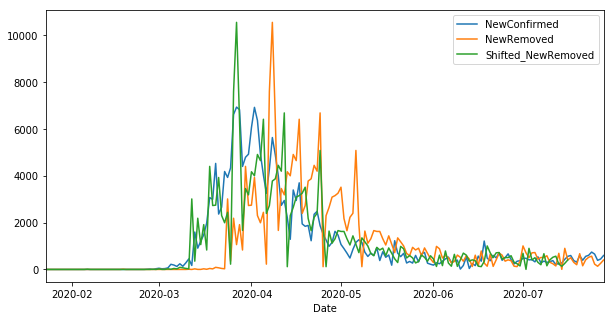

In [189]:
array = repro_df.values.T
shift = pd.np.correlate(array[0], array[1],"same").argmax() - len(repro_df)/2
# More exact would be some fitting and comparing, but this will do for now

print("Shifting by ",shift," Gives the best alignment of cases")
repro_df["Shifted_NewRemoved"] = repro_df.loc[:,"NewRemoved"].shift(int(shift))
repro_df.plot(figsize = (10,5))

# Compute an approximation of the Base reproductive number

## Reproductive number

In [194]:
df["Repro"] = df["NewConfirmed"]/df["NewConfirmed"].groupby(level = 0).rolling(int(-shift), center = False ).mean().values
df["weeklyRepro"] = df.groupby(level = 0)["Repro"].rolling(7, center = True ).mean().values
df["Impact"] = df["Repro"]*df["NewConfirmed"].groupby(level = 0).rolling(7, center = False ).mean().values

# Plot Reproductive number approximation

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


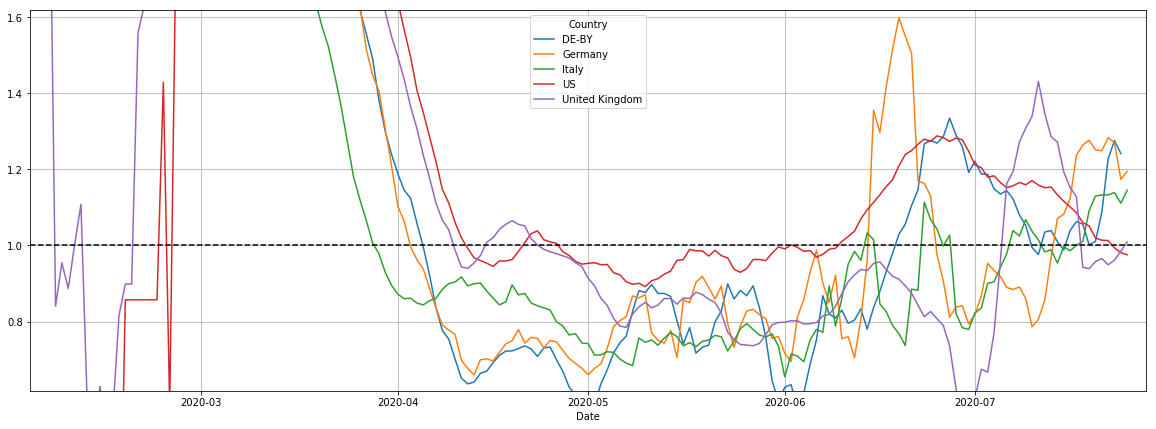

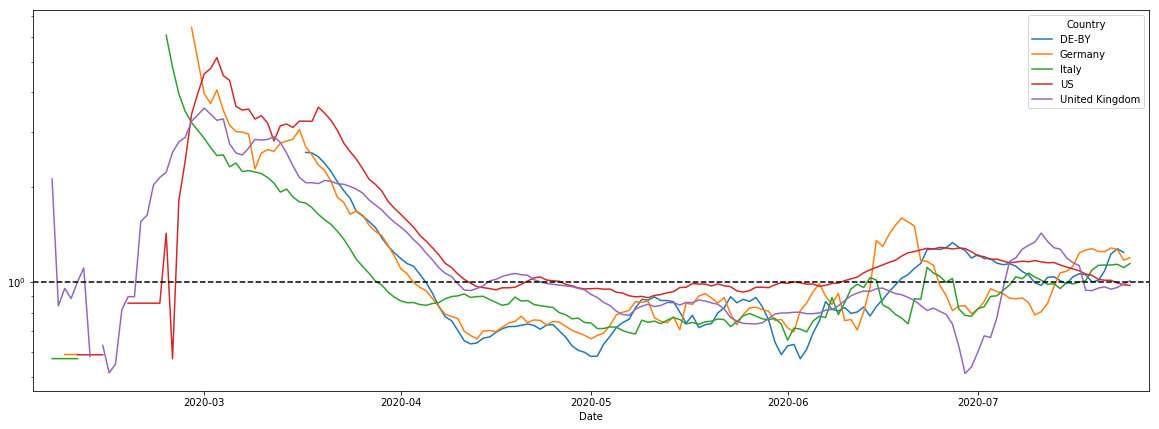

In [195]:
# Filter ...
to_plot = df.loc[
    df.index.get_level_values("Country").isin(countries),
    df.columns.get_level_values(0).isin(["weeklyRepro", "Impact"])
    ]

# .. and plot 
unstacked = to_plot.unstack(level="Country").dropna(how = 'all')

ax = unstacked["weeklyRepro"].plot(
    figsize = (20,7), 
    logy=False,
    ylim = (0.61803,1.61803), # Easter egg
    grid = True 
);
ax.plot(ax.get_xlim(),[1.0,1.0], "k--") # Add the line at "1"


ax2 = unstacked[unstacked>0.5]["weeklyRepro"].plot(
    figsize = (20,7), 
    logy=True,
);

ax2.plot(ax.get_xlim(),[1.0,1.0], "k--")                

## Plot current impact

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


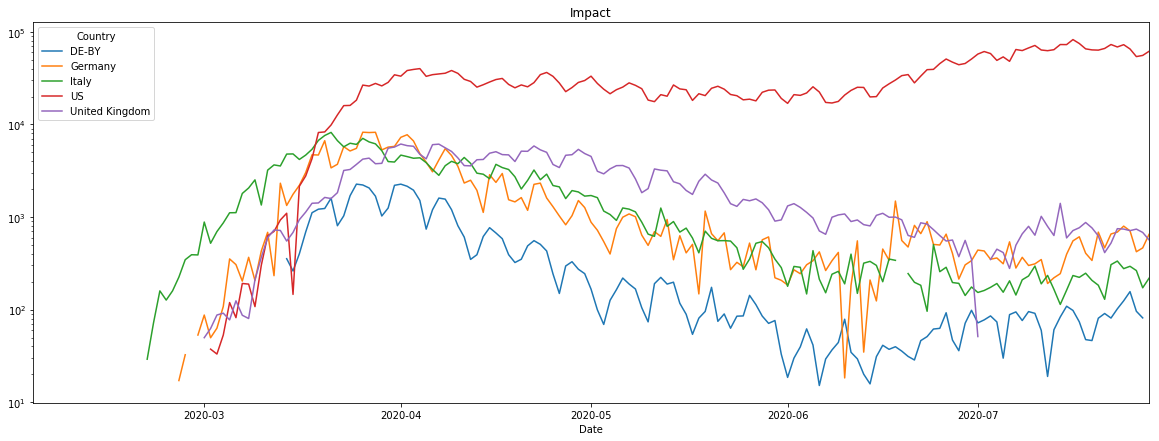

In [196]:
ax3 = unstacked[unstacked>15]["Impact"].plot(title = "Impact",
    figsize = (20,7), 
    logy=True                                              
);                            
               